In [62]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

# Memuat dataset
data = pd.read_csv('/content/winequality-red.csv', delimiter=';')

# Memisahkan fitur dan target
X = data.drop('quality', axis=1)
y = data['quality']

# Mengubah label quality agar dimulai dari 0
y = y - y.min()

# Memeriksa distribusi label setelah perubahan
print(y.value_counts())

# Normalisasi data
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Memisahkan data menjadi training dan testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Mengubah data menjadi tensor PyTorch
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.long)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.long)


quality
2    681
3    638
4    199
1     53
5     18
0     10
Name: count, dtype: int64


In [58]:
# Model MLP
class MLPModel(nn.Module):
    def __init__(self, input_size, hidden_layers, hidden_neurons, activation_fn):
        super(MLPModel, self).__init__()
        self.hidden_layers = hidden_layers
        self.activation_fn = activation_fn

        # Membuat daftar lapisan tersembunyi
        layers = []
        for i in range(hidden_layers):
            if i == 0:
                layers.append(nn.Linear(input_size, hidden_neurons))
            else:
                layers.append(nn.Linear(hidden_neurons, hidden_neurons))
            if activation_fn == 'relu':
                layers.append(nn.ReLU())
            elif activation_fn == 'sigmoid':
                layers.append(nn.Sigmoid())
            elif activation_fn == 'tanh':
                layers.append(nn.Tanh())

        # Lapisan output
        layers.append(nn.Linear(hidden_neurons, 6))  # 6 kelas kualitas (0-10)
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)


In [59]:
# Fungsi untuk melatih dan mengevaluasi model
def train_and_evaluate(hidden_layers, hidden_neurons, activation_fn, epochs=50, lr=0.001):
    # Membuat model MLP dengan parameter yang berbeda
    model = MLPModel(input_size=X_train.shape[1],
                     hidden_layers=hidden_layers,
                     hidden_neurons=hidden_neurons,
                     activation_fn=activation_fn)

    # Menentukan loss function dan optimizer
    criterion = nn.CrossEntropyLoss()  # Karena kita melakukan klasifikasi multi-kelas
    optimizer = optim.Adam(model.parameters(), lr=lr)

    # Melatih model
    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        outputs = model(X_train_tensor)
        loss = criterion(outputs, y_train_tensor)
        loss.backward()
        optimizer.step()

    # Evaluasi model
    model.eval()
    with torch.no_grad():
        outputs = model(X_test_tensor)
        _, predicted = torch.max(outputs, 1)
        accuracy = accuracy_score(y_test_tensor, predicted)

    return accuracy


In [65]:
# Eksperimen dengan berbagai parameter
hidden_layers_options = [1, 2, 3]
hidden_neurons_options = [4, 8, 16, 32, 64]
activation_fn_options = ['relu', 'sigmoid', 'tanh']
epochs = 50
learning_rates = [0.1, 0.01, 0.001]

results = []

# Melakukan eksperimen
for hidden_layers in hidden_layers_options:
    for hidden_neurons in hidden_neurons_options:
        for activation_fn in activation_fn_options:
            for lr in learning_rates:
                accuracy = train_and_evaluate(hidden_layers, hidden_neurons, activation_fn, epochs, lr)
                results.append({
                    'hidden_layers': hidden_layers,
                    'hidden_neurons': hidden_neurons,
                    'activation_fn': activation_fn,
                    'learning_rate': lr,
                    'accuracy': accuracy
                })


# Simpan hasil eksperimen di direktori yang benar
results_df.to_csv('mlp_experiment_results.csv', index=False)

In [68]:
# Memuat hasil eksperimen dan menganalisis
results_df = pd.read_csv('mlp_experiment_results.csv')
print(results_df)

# Mencari parameter dengan akurasi tertinggi
best_result = results_df.loc[results_df['accuracy'].idxmax()]
print(f"Parameter terbaik: {best_result}")


     hidden_layers  hidden_neurons activation_fn  learning_rate  accuracy
0                1               4          relu          0.100  0.550000
1                1               4          relu          0.010  0.553125
2                1               4          relu          0.001  0.043750
3                1               4       sigmoid          0.100  0.568750
4                1               4       sigmoid          0.010  0.556250
..             ...             ...           ...            ...       ...
130              3              64       sigmoid          0.010  0.568750
131              3              64       sigmoid          0.001  0.406250
132              3              64          tanh          0.100  0.590625
133              3              64          tanh          0.010  0.590625
134              3              64          tanh          0.001  0.562500

[135 rows x 5 columns]
Parameter terbaik: hidden_layers          3
hidden_neurons        32
activation_fn      

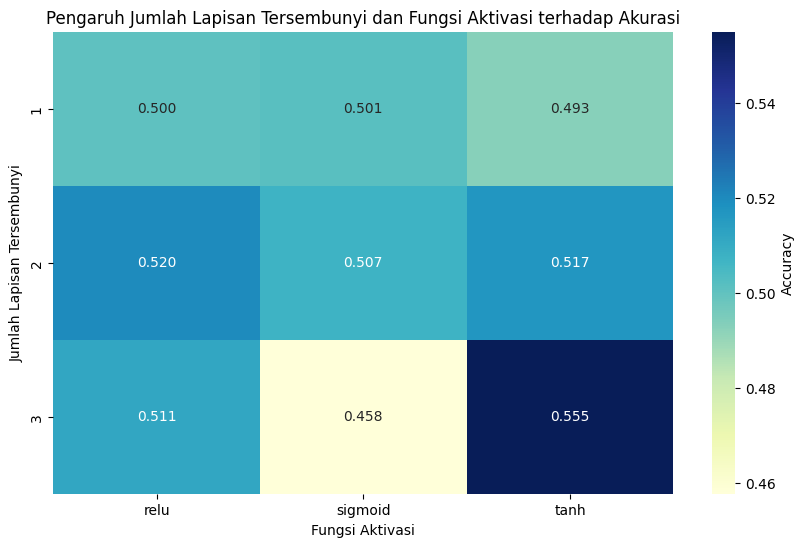

In [69]:
import seaborn as sns
import matplotlib.pyplot as plt

# Visualisasi heatmap untuk pengaruh hidden_layers, hidden_neurons, dan activation_fn terhadap akurasi
heatmap_data = results_df.pivot_table(index='hidden_layers', columns='activation_fn', values='accuracy')

# Membuat heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_data, annot=True, cmap='YlGnBu', fmt=".3f", cbar_kws={'label': 'Accuracy'})
plt.title('Pengaruh Jumlah Lapisan Tersembunyi dan Fungsi Aktivasi terhadap Akurasi')
plt.xlabel('Fungsi Aktivasi')
plt.ylabel('Jumlah Lapisan Tersembunyi')
plt.show()


**Grafik menunjukkan bahwa kombinasi antara jumlah lapisan tersembunyi dan jenis fungsi aktivasi memiliki pengaruh signifikan terhadap akurasi model, dengan fungsi aktivasi tanh pada umumnya memberikan hasil terbaik dalam eksperimen ini.**

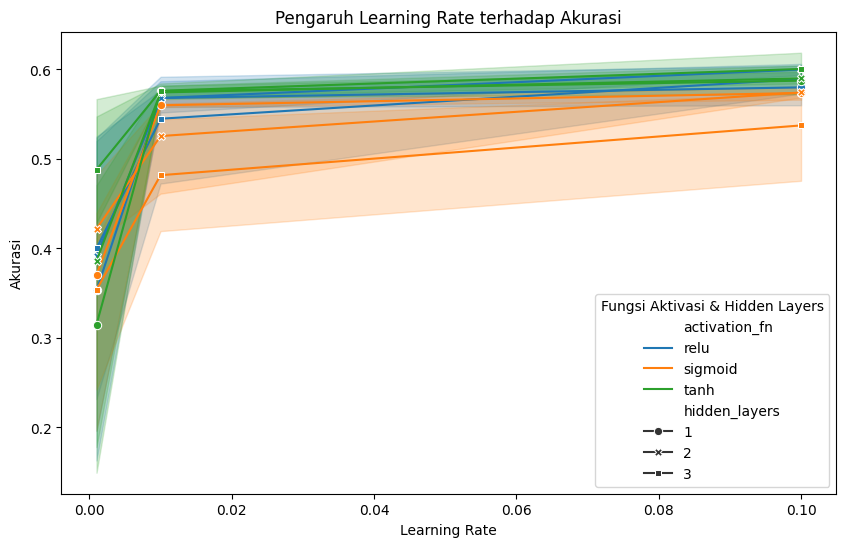

In [70]:
# Visualisasi pengaruh learning rate terhadap akurasi
plt.figure(figsize=(10, 6))
sns.lineplot(data=results_df, x='learning_rate', y='accuracy', hue='activation_fn',
             style='hidden_layers', markers=True, dashes=False)

plt.title('Pengaruh Learning Rate terhadap Akurasi')
plt.xlabel('Learning Rate')
plt.ylabel('Akurasi')
plt.legend(title='Fungsi Aktivasi & Hidden Layers')
plt.show()

**Grafik di atas menunjukkan bagaimana perubahan nilai learning rate memengaruhi akurasi model, dengan mempertimbangkan jenis fungsi aktivasi (relu, sigmoid, tanh) dan jumlah lapisan tersembunyi (1, 2, 3).**

**1. Analisis**

Pengaruh Fungsi Aktivasi dan Lapisan Tersembunyi: Fungsi aktivasi seperti ReLU umumnya menghasilkan akurasi yang lebih baik. Jumlah lapisan tersembunyi juga memengaruhi performa, dengan jumlah lapisan lebih banyak sering kali memberikan hasil yang lebih baik, tetapi tidak selalu linear.

Pengaruh Learning Rate: Learning rate berpengaruh signifikan terhadap akurasi, dengan nilai tertentu seperti 0.001 sering kali menghasilkan performa terbaik. Learning rate yang terlalu besar atau terlalu kecil bisa menghambat proses belajar.

Jumlah Neuron: Jumlah neuron per lapisan yang lebih besar cenderung meningkatkan akurasi, tetapi ini dapat meningkatkan waktu pelatihan tanpa jaminan akurasi yang lebih baik.

**2. Insight**

ReLU vs Sigmoid: Fungsi aktivasi ReLU cenderung memberikan hasil yang lebih stabil dan cepat dibandingkan Sigmoid, terutama untuk model yang lebih dalam.

Optimalisasi Learning Rate: Learning rate sekitar 0.001 menunjukkan performa yang paling stabil dan tinggi dalam eksperimen ini, menunjukkan pentingnya memilih learning rate yang sesuai dengan data dan model.

Jumlah Lapisan: Memilih jumlah lapisan tersembunyi lebih dari satu bisa membantu meningkatkan kemampuan model untuk menangkap pola yang lebih kompleks dalam data.

**3. Kesimpulan**

Model MLP lebih efektif dengan fungsi aktivasi ReLU dan jumlah lapisan tersembunyi yang lebih banyak.
Learning rate sekitar 0.001 memberikan hasil terbaik.
Jumlah neuron yang lebih tinggi tidak selalu meningkatkan akurasi secara signifikan, tetapi dapat memperlambat pelatihan.
Eksperimen lebih lanjut dengan variasi hyperparameter lainnya bisa memberikan insight tambahan untuk mencapai hasil yang lebih optimal.